# Index Sort Data Analysis


First, we want to know how reliable index sort flurecent readouts are. 

> Attached please find zipped raw index sort csv files for GCs that I have index sort for, and also my work-in-progress GC database containing only relevant(?) columns.

>Just to note, that for index sort files you would need to skip several lines at the top before importing the data table.
Unfortunately column names are not always consistent (we used two sorters simultaneously to sort) so you might need to grep for “IGY” for chigy (antigen) and “IGK” for kappa.

> For kappa, it can be RFP or tdTomato depending on which files, but they are functionally the same.
For some reason the export files contain Mean, Geo Mean, and Median for each colors but they are mostly the same. I suggest to take Geo Mean or Median because Mean might have some negative values which would make no sense for the analysis (this has to do with flow cytometry compensation). Where mean gives negative values, Geo Mean /Median is empty.

>GC database is relatively straightforward. Minimally, the columns to focus would be GC_num and well, which would tell you which cells to join the index sort values to.

>I do have additive values of deltaKD, deltaExpression, and deltaPSR based on final variant score table that Tyler posted some time ago. I think there was one cell which had a mutation that DMS didn’t have a value for, and that was simply ignored.
If need be, I also do have list of HC and LC mutations (HCmut and LCmut) separated by a colon for every cells, if re-calculation etc. is needed.

> fasta_gctree_HK is the input sequence used for gctree. You will find, for convenience, that I also have H alone (fasta_gctree_H), K alone (fasta_gctree_K), and amino acid version of the concatenated sequence (seq_aa_HK) if needed. It might potentially be helpful for @psathyrella if you still need to supply only H or K sequence to partis to get the selection metrics. - T

In [1]:
import copy
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import torch
from Bio.Seq import Seq

### First, Sort Files Explore

In [2]:
! tree data/ | head

data/
├── 211015 PR1.1
│   ├── gc20HK-BC1
│   │   ├── abundances.csv
│   │   ├── deduplicated.phylip
│   │   ├── dnapars.cfg
│   │   ├── gctree.out.inference.1.fasta
│   │   ├── gctree.out.inference.1 gc20HK BC1.pdf
│   │   ├── gctree.out.inference.1.nk
│   │   ├── gctree.out.inference.1.p


In [3]:
! ls -a data/sort_data

 .			   '210901 INX_GC42_001.csv'  '210901 INX_GC67_001.csv'
 ..			   '210901 INX_GC43_001.csv'  '210901 INX_GC68_001.csv'
'210831 INX_GC21_001.csv'  '210901 INX_GC44_001.csv'  '210901 INX_GC69_001.csv'
'210831 INX_GC22_001.csv'  '210901 INX_GC45_001.csv'  '210901 INX_GC70_001.csv'
'210831 INX_GC23_001.csv'  '210901 INX_GC46_001.csv'  '210901 INX_GC71_001.csv'
'210831 INX_GC24_001.csv'  '210901 INX_GC47_001.csv'  '210901 INX_GC72_001.csv'
'210831 INX_GC25_001.csv'  '210901 INX_GC47_002.csv'  '210901 INX_GC73_001.csv'
'210831 INX_GC26_001.csv'  '210901 INX_GC48_001.csv'  '210902 INX_GC74_001.csv'
'210831 INX_GC28_001.csv'  '210901 INX_GC50_001.csv'  '210902 INX_GC75_001.csv'
'210831 INX_GC29_001.csv'  '210901 INX_GC55_001.csv'  '210902 INX_GC76_001.csv'
'210831 INX_GC30_001.csv'  '210901 INX_GC56_001.csv'  '210902 INX_GC77_001.csv'
'210831 INX_GC31_001.csv'  '210901 INX_GC57_001.csv'  '210902 INX_GC78_001.csv'
'210831 INX_GC32_001.csv'  '210901 INX_GC58_001.csv'  '210902 INX_GC79_001.cs

In [4]:
! ls -l data/sort_data/*.csv | wc -l

51


Looks like we have 50 total sort files, 13 lines need to be skipped for each.

In [5]:
sort_file = pd.read_csv("data/sort_data/210831 INX_GC21_001.csv", skiprows=13)

In [6]:
! head -n 13 'data/sort_data/210831 INX_GC21_001.csv'

In [7]:
print(sort_file.columns)

Index(['Well', 'All Events #Events', 'All Events PA+ GFP-A Geo Mean',
       'All Events PA+ GFP-A Mean', 'All Events PA+ GFP-A Median',
       'All Events CD38 APC-A Geo Mean', 'All Events CD38 APC-A Mean',
       'All Events CD38 APC-A Median', 'All Events TCRB APC-Cy7-A Geo Mean',
       'All Events TCRB APC-Cy7-A Mean', 'All Events TCRB APC-Cy7-A Median',
       'All Events IGY BV421-A Geo Mean', 'All Events IGY BV421-A Mean',
       'All Events IGY BV421-A Median',
       'All Events PA Pacific Orange-A Geo Mean',
       'All Events PA Pacific Orange-A Mean',
       'All Events PA Pacific Orange-A Median', 'All Events BV650-A Geo Mean',
       'All Events BV650-A Mean', 'All Events BV650-A Median',
       'All Events IGK RFP-A Geo Mean', 'All Events IGK RFP-A Mean',
       'All Events IGK RFP-A Median', 'All Events FAS PE-Cy7-A Geo Mean',
       'All Events FAS PE-Cy7-A Mean', 'All Events FAS PE-Cy7-A Median',
       'All Events B220 BV786-A Geo Mean', 'All Events B220 BV786-A Mea

In [8]:
sort_file

,Well,All Events #Events,All Events PA+ GFP-A Geo Mean,All Events PA+ GFP-A Mean,All Events PA+ GFP-A Median,All Events CD38 APC-A Geo Mean,All Events CD38 APC-A Mean,All Events CD38 APC-A Median,All Events TCRB APC-Cy7-A Geo Mean,All Events TCRB APC-Cy7-A Mean,...,All Events IGK RFP-A Median,All Events FAS PE-Cy7-A Geo Mean,All Events FAS PE-Cy7-A Mean,All Events FAS PE-Cy7-A Median,All Events B220 BV786-A Geo Mean,All Events B220 BV786-A Mean,All Events B220 BV786-A Median,All Events Time Geo Mean,All Events Time Mean,All Events Time Median
0,A1,1,"1,154","1,154","1,154",NaN,-63,-63,222.0,222,...,67,797,797,797,"2,001","2,001","2,001","2,889","2,889","2,889"
1,A2,1,"2,062","2,062","2,062",36.0,36,36,67.0,67,...,214,"1,356","1,356","1,356","4,459","4,459","4,459","3,527","3,527","3,527"
2,A3,1,"3,335","3,335","3,335",177.0,177,177,12.0,12,...,187,"1,163","1,163","1,163","4,184","4,184","4,184","3,740","3,740","3,740"
3,A4,1,"2,076","2,076","2,076",NaN,-35,-35,203.0,203,...,212,"1,018","1,018","1,018","1,424","1,424","1,424","6,019","6,019","6,019"
4,A5,1,"1,663","1,663","1,663",213.0,213,213,139.0,139,...,165,"1,157","1,157","1,157","3,866","3,866","3,866","6,505","6,505","6,505"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,H8,1,"4,903","4,903","4,903",44.0,44,44,206.0,206,...,97,913,913,913,"2,546","2,546","2,546","71,203","71,203","71,203"
92,H9,1,"2,911","2,911","2,911",23.0,23,23,9.0,9,...,176,659,659,659,"1,485","1,485","1,485","70,331","70,331","70,331"
93,H10,1,"1,347","1,347","1,347",0.0,0,0,50.0,50,...,59,522,522,522,"1,789","1,789","1,789","69,168","69,168","69,168"
94,H11,1,"1,611","1,611","1,611",NaN,-9,-9,99.0,99,...,-32,669,669,669,"2,689","2,689","2,689","67,253","67,253","67,253"


In [9]:

total = 0
for f in glob.glob("data/sort_data/*.csv"):
    sort_file = pd.read_csv(f, skiprows=13)
    num_well = len(set(sort_file["Well"]))
    flag = ""
    if len(sort_file) != 96:
        flag += "!!!"
    total += len(sort_file)
    print(f, len(sort_file), num_well, flag)
print(total)

data/sort_data/210901 INX_GC55_001.csv 96 96 
data/sort_data/210901 INX_GC42_001.csv 96 96 
data/sort_data/210901 INX_GC73_001.csv 96 96 
data/sort_data/210901 INX_GC50_001.csv 96 96 
data/sort_data/210901 INX_GC46_001.csv 96 96 
data/sort_data/210901 INX_GC63_001.csv 96 96 
data/sort_data/210902 INX_GC76_001.csv 96 96 
data/sort_data/210901 INX_GC59_001.csv 96 96 
data/sort_data/210901 INX_GC45_001.csv 96 96 
data/sort_data/210831 INX_GC31_001.csv 96 96 
data/sort_data/210901 INX_GC71_001.csv 96 96 
data/sort_data/210901 INX_GC70_001.csv 96 96 
data/sort_data/210902 INX_GC80_001.csv 96 96 
data/sort_data/210831 INX_GC30_001.csv 96 96 
data/sort_data/210902 INX_GC79_001.csv 96 96 
data/sort_data/210831 INX_GC29_001.csv 96 96 
data/sort_data/210902 INX_GC81_001.csv 96 96 
data/sort_data/210902 INX_GC82_001.csv 96 96 
data/sort_data/210831 INX_GC23_001.csv 77 77 !!!
data/sort_data/210901 INX_GC47_001.csv 10 10 !!!
data/sort_data/210901 INX_GC67_001.csv 96 96 
data/sort_data/210831 INX_GC

### Collect and clean sort file

In [10]:
database_fn = "211021PR1_total_select.csv"
new_cols = ["chigy", "kappa", "sorter"]
join_on = ["GC_num", "well"]

In [11]:
chigy_col = "All Events IGY BV421-A Mean"
kappa_col_1 = "All Events IGK RFP-A Mean"
kappa_col_2 = "All Events IGK tdTomato-A Mean"

flur_df = pd.DataFrame({
    f:[]
    for f in new_cols + join_on
})

def format_well_string(wst):
    try:
        return wst[0] + wst[1:].zfill(2) 
    except:
        raise ValueError(f"Oops, must pass a string with a single charicter before int")

for i, f in enumerate(glob.glob("data/sort_data/*.csv")):
    sort_file = pd.read_csv(f, skiprows=13)
    sorter, kc = ("RFP", kappa_col_1) if kappa_col_1 in sort_file.columns else ("tdTomato", kappa_col_2)
    doi = copy.deepcopy(sort_file[["Well", chigy_col,kc]])
    doi.rename({chigy_col:"chigy", kc:"kappa", "Well": "well"}, axis=1, inplace=True)
    if doi.dtypes["chigy"] != int:
        doi["chigy"] = doi["chigy"].str.replace(",", "").astype(int)
    if doi.dtypes["kappa"] != int:
        doi["kappa"] = doi["kappa"].str.replace(",", "").astype(int)
    doi["well"] = [format_well_string(w) for w in doi["well"]]
    fn = os.path.basename(f)
    GC_num = int(fn.split("_")[1][2:])
    doi["GC_num"] = int(GC_num)
    doi["sorter"] = sorter
    flur_df = flur_df.append(doi)

flur_df["GC_num"] = flur_df["GC_num"].astype(int)
flur_df["kappa"] = flur_df["kappa"].astype(int)
flur_df["chigy"] = flur_df["chigy"].astype(int)
flur_df.loc[flur_df["chigy"] < 0, "chigy"] = 0 
flur_df.loc[flur_df["kappa"] < 0, "kappa"] = 0 

### Now, we have a clean index sort df

In [12]:
flur_df

,chigy,kappa,sorter,GC_num,well
0,3513,365,tdTomato,55,A01
1,248,79,tdTomato,55,A02
2,5081,742,tdTomato,55,A03
3,2519,307,tdTomato,55,A04
4,4802,447,tdTomato,55,A05
...,...,...,...,...,...
91,1375,175,RFP,56,H08
92,2179,291,RFP,56,H09
93,1560,191,RFP,56,H10
94,1003,134,RFP,56,H11


### Merge it with database of existing cell annotations

In [13]:
db = pd.read_csv(f"data/{database_fn}")
db = db[db["mouse"]!=1].set_index(join_on)

flur_df = flur_df.set_index(join_on)

db_cells = set(db.index.values)
cc_cells = set(flur_df.index.values)

#print(f"There are {len(db_cells)} currently sequenced, and {len(cc_cells)} index sorted cells with kappa/chigy")
#print(f"There are {len(set.intersection(db_cells, cc_cells))} overlappings cells from both")

merged_index_db = db.merge(flur_df, left_index=True, right_index=True, how="outer")
merged_db = merged_index_db.query("ID_HK.notnull() & chigy.notnull() & kappa.notnull()").reset_index()

### From Zorian: translating aa from heavy and light chains

In [14]:
wtseq_path = "data/wildtype_sequence.fasta"
# gc_data = merged_db

In [15]:
with open(wtseq_path) as f:
    wt_seq = f.readlines()
wt_seq = Seq(wt_seq[1])
%matplotlib inline

#### Missing codon in GC BCRs
* There's a missing codon from Tatsuya's data, the last one (HC:R235)
* To patch this for now, I'll just add the WT amino acid from Tyler's DMS to every sequence in Tatsuya's data. Maybe this was an oversight on Tatsuya's end? Or did Tyler include an extra aa in his DMS?

In [16]:
wtseq_path = "data/wildtype_sequence.fasta"
with open(wtseq_path) as f:
    wt_seq = f.readlines()
wt_seq = Seq(wt_seq[1])
# Linker sequence from Tyler's DMS
linker = "ggtggtggcggatccggtggcggtgggtcaggaggaggcggctct"

# Get a sequence with no mutations
merged_db[merged_db['aa_replacement_total'] == 0].head()

lc = Seq(merged_db['fasta_gctree_K'][684].split('\n')[1])
hc = Seq(merged_db['fasta_gctree_H'][684].split('\n')[1])
seq_aa_HK = merged_db["seq_aa_HK"][684]
print(f"Length of DNA in GC BCRs (Tatsuya): {len(hc + linker + lc)}")
print(f"Length of DNA in DMS (Tyler): {len(wt_seq)}")
print(f"Length of seq_aa_HK in GC (Tatsuya): {len(seq_aa_HK)}\n")


print(f"First 10 amino acids of Tyler's HC:\t {wt_seq[:30].translate()}")
print(f"First 10 amino acids of Tatsuya's HC:\t {hc[:30].translate()}\n")

# Last ten amino acids of Tyler's DMS
print(f"Last 10 amino acids of Tyler's LC:\t {wt_seq[-30:].translate()}")
print(f"Last 10 amino acids of Tatsuya's LC:\t {lc[-30:].translate()}\n")

Length of DNA in GC BCRs (Tatsuya): 702
Length of DNA in DMS (Tyler): 705
Length of seq_aa_HK in GC (Tatsuya): 219

First 10 amino acids of Tyler's HC:	 EVQLQESGPS
First 10 amino acids of Tatsuya's HC:	 EVQLQESGPS

Last 10 amino acids of Tyler's LC:	 GSGTKLEIKR
Last 10 amino acids of Tatsuya's LC:	 FGSGTKLEIK



In [17]:
#### Append heavy chain, linker, and light chain together

# Very stupid, brute force way to do this.
nt_seqs = []
aa_seqs = []
for i in range(merged_db.shape[0]):
    hc_seq = merged_db['fasta_gctree_H'][i].split('\n')[1]
    lc_seq = merged_db['fasta_gctree_K'][i].split('\n')[1]
    total_seq = hc_seq + linker + lc_seq + 'AGA'
    nt_seqs.append(total_seq)
    aa_seqs.append(Seq(total_seq).translate())

# print(aa_seqs)
merged_db["full_nt_seq"] = nt_seqs
merged_db["full_aa_seq"] = aa_seqs

## Adding slope to cells with BCR sequence replicates >=5

In [18]:
# merged_db["full_aa_seq"].value_counts()

### TODO: Naive sequence chingy/kappa ratio

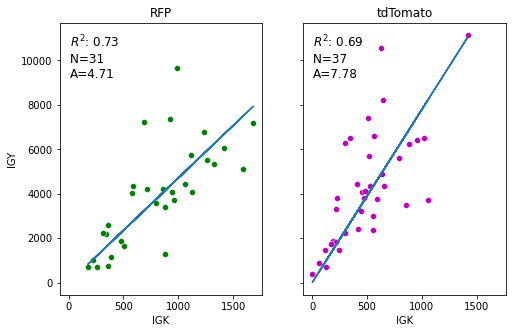

In [19]:
concat_left = pd.read_csv("data/concat_1_PR1left-nonGC-PA_cIgY+_stain.csv")
concat_right = pd.read_csv("data/concat_1_PR1right-nonGC-PA_cIgY+_stain.csv")

concat_right = concat_right[concat_right.IGK <= 3000]
fig, ax = plt.subplots(1, 2, figsize = [8, 5], sharex=True, sharey=True)
title = ["RFP", "tdTomato"]
# colors = [""]
colors=["g", "m"]
naive_slopes = {}
for i, sorter in enumerate([concat_right, concat_left]):
    x = sorter.IGK
    y = sorter.IGY
    r2 = st.pearsonr(x,y)[0]
    sns.scatterplot(
        data=sorter, 
        x="IGK", 
        y="IGY", 
        ax=ax[i], 
        color = colors[i]
    )
    
    xa = np.array(x)[:, np.newaxis]
    a, _, _, _ = np.linalg.lstsq(xa, y, rcond=None)
    naive_slopes[title[i]] = a[0]
    ax[i].plot(xa, xa*a)
    
    ax[i].set_title(title[i])
    ax[i].annotate(
        f"$R^{2}$: {round(r2, 2)}\nN={len(x)} \nA={round(a[0], 2)}",
        xy=[0.05, 0.8], 
        size=12, 
        xycoords="axes fraction"
    )
fig.savefig("figures/naive-yk-slope.pdf")

### Next, plot best fit lines for "top ranked" mutated BCR sequence replicates

BCR's are ranked by the number of replicate BCR sequences for any one mutant.

1. we want to lock the y-intercept at zero
2. we want to do this for all sequence replicates such that at least five replicates exist in the dataframe
3. For all replicates where there is at least five replicates we add the slope, "A"

In [20]:
# the minimum number of sequence replicates one BCR must possess in the
# dataset to be considered in the comparison.

min_seq_reps = 3

In [21]:
merged_db["kc_slope"] = np.nan
for seq, seq_db in merged_db.groupby("full_aa_seq"):
#     if len(seq_db) < 5: continue
#     print(seq_db.index.values)
    x = np.array(seq_db.loc[:, "kappa"].values)
    y = np.array(seq_db.loc[:, "chigy"].values)
    x = x[:, np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
    merged_db.loc[seq_db.index.values, "kc_slope"] = np.repeat(a, len(seq_db))
    
    sorter = list(set(seq_db.sorter))[0]
    ss = naive_slopes[sorter]
    merged_db.loc[seq_db.index.values, "delta_kc_slope"] = np.repeat(a[0]-ss, len(seq_db))    

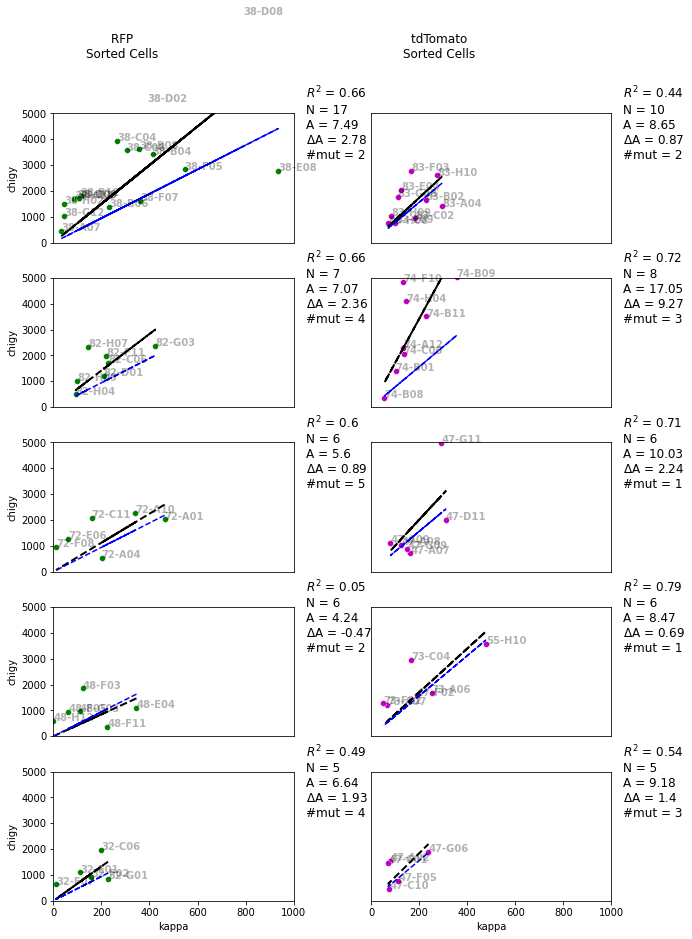

In [22]:
fig = plt.figure(figsize=[10, 16])
axd = fig.subplot_mosaic(
    """
    K.L.
    AAFF
    AAFF
    BBGG
    BBGG
    CCHH
    CCHH
    DDII
    DDII
    EEJJ
    EEJJ
    """,
    gridspec_kw = {
        "wspace" : 0.95,
        "hspace" : 0.75
    }
)

layout = [
    ["A", "B", "C", "D", "E"], 
    ["F", "G", "H", "I", "J"]
]

sorters = []
colors=["g", "m"]
first = True
for sub_keys, (sorter, sorter_df), c in zip(layout, merged_db.groupby("sorter"), colors):
    sorters.append(sorter)
    vc = sorter_df["full_aa_seq"].value_counts()
    for rank_seq in range(len(sub_keys)):
        seq = vc.index[rank_seq]
        replicates = sorter_df.query(f"full_aa_seq == '{seq}'")
        r2 = st.pearsonr(replicates["chigy"], replicates["kappa"])[0]
        curr_ax = axd[sub_keys[rank_seq]]
        g = sns.scatterplot(
            y = "chigy", 
            x = "kappa", 
            data=replicates,
            ax = curr_ax,
            color = c,
            #scatter_kws = {"s":replicates["deltaKd"]*10}
        )
        
        x = np.array(replicates.loc[:, "kappa"].values)
        a = list(set(replicates["kc_slope"]))
        assert len(a) == 1
        a = a[0]
        x = x[:, np.newaxis]

        
        curr_ax.plot(x, a*x, 
                     color='black', 
                     linestyle='dashed', 
                     linewidth=2
                    )
        ss = naive_slopes[sorter]
        curr_ax.plot(x, ss*x, 
                     color='blue', 
                     linestyle='dashed', 
                     linewidth=1.5
                    )
        delta_a = round(a-ss, 2)
        nm = list(set(replicates["aa_replacement_total"]))
        assert len(nm) == 1
        nm = int(nm[0])
        curr_ax.set_xlim(0, 1000)
        curr_ax.set_ylim(0, 5000)

        curr_ax.annotate(
            f"$R^{2}$ = {round(r2, 2)}\nN = {len(replicates)}\nA = {round(a, 2)}\n$\Delta$A = {delta_a}\n#mut = {nm}",
            xy=[1.05, 0.65], 
            size=12, 
            xycoords="axes fraction"
        )
        for line in range(0,replicates.shape[0]):
            curr_ax.text(replicates.kappa.values[line]+0.2,
                     replicates.chigy.values[line],
                     str(replicates["GC_num"].values[line]) +"-"+ replicates["well"].values[line],
                     #replicates.ID_HC.values[line],
                     horizontalalignment='left',
                     size='medium',
                     color='black',
                     weight='semibold',
                     alpha = 0.3
            )
        if rank_seq != (len(sub_keys)-1):
            curr_ax.set_xlabel("")
            curr_ax.get_xaxis().set_visible(False)
        if not first: 
            curr_ax.set_ylabel("")
            curr_ax.get_yaxis().set_visible(False)
            
    first = False


axd["K"].axis("off")
axd["K"].text(0.65, 0.05,
        f"""
        {sorters[0]}
        Sorted Cells
        """, 
        size=12, rotation=0,
        ha="center", va="bottom",
)
axd["L"].axis("off")
axd["L"].text(0.65, 0.05,
        f"""
        {sorters[1]}
        Sorted Cells
        """, 
        size=12, rotation=0,
        ha="center", va="bottom",
)
# plt.tight_layout()
fig.savefig("figures/top-five-seq-replicates-ky-slope.pdf")

In [23]:
# 1 load in the "data/concat" files
# see what they look like re column names
# figure out how to get the kappa / chigy ratio

In [24]:
# print(concat_left.columns)
# print(concat_right.columns)
# print(f" right but not left: {set(concat_right.columns) - set(concat_left.columns)}")
# print(f" left but not right: {set(concat_left.columns) - set(concat_right.columns)}")

In [25]:
# print(concat_left)
# print(concat_right)

### Merge torchdms predictions for each of the cells

In [26]:
# load in the model 
model_path = "data/mse.model"
model = torch.load(model_path)

In [27]:
### Format data for `torchdms`

# Generate tensors of Tatsuya's data.
input_dim = model.input_size
n_cells = len(merged_db)
tdms_reps = torch.zeros(size=(n_cells, input_dim))
for i in range(len(aa_seqs)):
    tdms_reps[i, :] = model.seq_to_binary(aa_seqs[i])

### `torchdms` predictions on Tatsuya's data

model.eval()
preds = model(tdms_reps)
# print(preds)
merged_db['tdms_pred_Kd'] = preds[:, 0].detach()
merged_db['tdms_pred_expr'] = preds[:, 1].detach()

YOOOOOOOOOOOOOOOO <class 'torchdms.model.FullyConnected'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>
YOOOOOOOOOOOOOOOO <class 'torchdms.model.FullyConnected'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>
YOOOOOOOOOOOOOOOO <class 'torchdms.model.FullyConnected'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>
YOOOOOOOOOOOOOOOO <class 'torch.nn.modules.linear.Linear'>


In [28]:
merged_db_fn = os.path.join("data", ".".join(database_fn.split(".")[:-1]) + "_merged_counts.csv")
# print(f"writing to {merged_db_fn}")
merged_db.to_csv(merged_db_fn, index=False)
merged_db

,GC_num,well,ID_HK,mouse,node,plate_num,cell_type,num_HC,barcode_HC,ID_HC,...,seq_aa_HK,chigy,kappa,sorter,full_nt_seq,full_aa_seq,kc_slope,delta_kc_slope,tdms_pred_Kd,tdms_pred_expr
0,32,A01,210923P04A01HK,2.0,LB,32.0,GC,1155.0,4.0,210923P04A01H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,527,116,RFP,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",4.543103,-0.168199,1.011213,-1.914282
1,32,A02,210923P04A02HK,2.0,LB,32.0,GC,1160.0,4.0,210923P04A02H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,224,0,RFP,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",0.000000,-4.711302,1.187544,-2.448499
2,32,A03,210923P04A03HK,2.0,LB,32.0,GC,1161.0,4.0,210923P04A03H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,141,12,RFP,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",11.750000,7.038698,0.407668,-2.398734
3,32,A04,210923P04A04HK,2.0,LB,32.0,GC,1164.0,4.0,210923P04A04H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,160,171,RFP,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",0.935673,-3.775630,0.649353,-2.431082
4,32,A05,210923P04A05HK,2.0,LB,32.0,GC,1167.0,4.0,210923P04A05H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,729,259,RFP,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",2.814672,-1.896630,0.136917,-0.514007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,83,H06,211006P12H06HK,5.0,RP,74.0,GC,3819.0,12.0,211006P12H06H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,746,72,tdTomato,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",8.650538,0.866346,0.325248,-0.050522
747,83,H09,211006P12H09HK,5.0,RP,74.0,GC,3835.0,12.0,211006P12H09H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1041,85,tdTomato,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",8.650538,0.866346,0.325248,-0.050522
748,83,H10,211006P12H10HK,5.0,RP,74.0,GC,3841.0,12.0,211006P12H10H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2598,276,tdTomato,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",8.650538,0.866346,0.325248,-0.050522
749,83,H11,211006P12H11HK,5.0,RP,74.0,GC,3847.0,12.0,211006P12H11H,...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,258,285,tdTomato,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,"(E, V, Q, L, Q, E, S, G, P, S, L, V, K, P, S, ...",0.905263,-6.878929,-1.378184,-1.756485


In [32]:
# print(merged_db)

### Pair plot for comparing tdms, additive model (observed), and kappa-chingy slope for all (>5) seq replicates 

In [ ]:
# seq_5_reps = merged_db.query("kc_slope.notnull()")

In [35]:
# print(seq_5_reps)

     GC_num well           ID_HK  mouse node  plate_num cell_type  num_HC  \
0        32  A01  210923P04A01HK    2.0   LB       32.0        GC  1155.0   
1        32  A02  210923P04A02HK    2.0   LB       32.0        GC  1160.0   
2        32  A03  210923P04A03HK    2.0   LB       32.0        GC  1161.0   
3        32  A04  210923P04A04HK    2.0   LB       32.0        GC  1164.0   
4        32  A05  210923P04A05HK    2.0   LB       32.0        GC  1167.0   
..      ...  ...             ...    ...  ...        ...       ...     ...   
746      83  H06  211006P12H06HK    5.0   RP       74.0        GC  3819.0   
747      83  H09  211006P12H09HK    5.0   RP       74.0        GC  3835.0   
748      83  H10  211006P12H10HK    5.0   RP       74.0        GC  3841.0   
749      83  H11  211006P12H11HK    5.0   RP       74.0        GC  3847.0   
750      83  H12  211006P12H12HK    5.0   RP       74.0        GC  3853.0   

     barcode_HC          ID_HC  ...  \
0           4.0  210923P04A01H  ... 

In [29]:
uniq_seqs = seq_5_reps.groupby("full_aa_seq").first().reset_index()

In [34]:
# print(uniq_seqs)

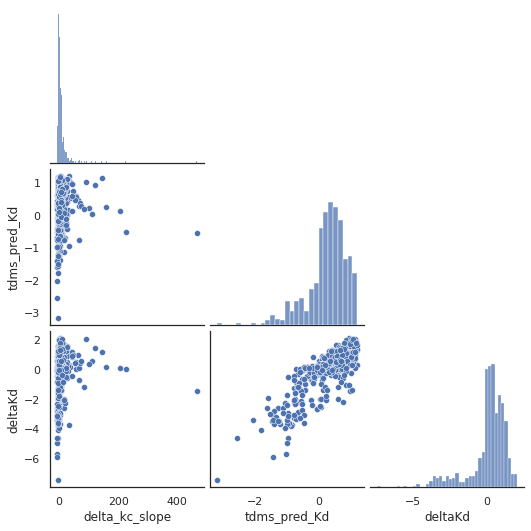

In [30]:
import seaborn as sns; sns.set(style='white')

# def corrfunc(x, y, ax=None, **kws):
#     """Plot the correlation coefficient in the top left hand corner of a plot."""
#     r, _ = st.pearsonr(x, y)
#     ax = ax or plt.gca()
#     ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(
    data=uniq_seqs,
#     hue="sorter",
    vars = ["delta_kc_slope", "tdms_pred_Kd", "deltaKd"],
    corner=True
)

# g.map_lower(corrfunc)
# plt.show()
plt.savefig("figures/tdms-delta-ky-slope-add-pairplot.pdf")

### Okay, so it seems like, at least with the data we have that. Le't maybe just look at overall KY ratio?

In [45]:
# look into this sample
# merged_db[merged_db.kappa.isna()]
merged_db = merged_db.query("kappa != 0 & chigy !=0")
merged_db = merged_db.replace([np.inf, -np.inf], np.nan)
merged_db = merged_db.query("tdms_pred_Kd.notnull() & deltaKd.notnull()")
merged_db["kc_ratio"] = np.log(merged_db["chigy"].values / merged_db["kappa"].values)

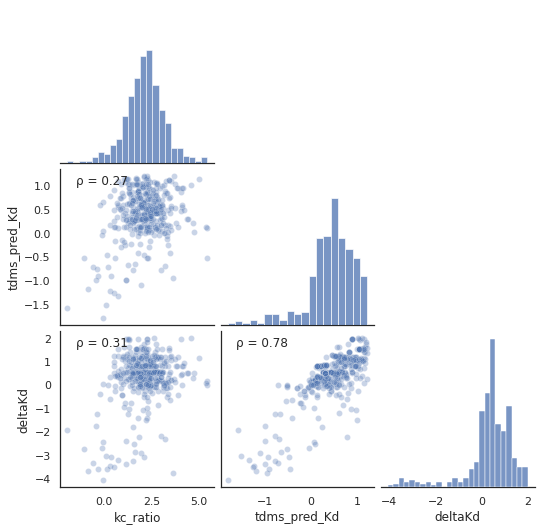

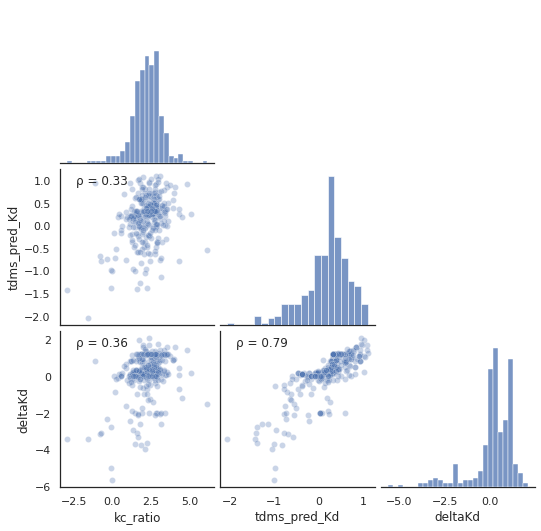

In [60]:
import seaborn as sns; sns.set(style='white')
# num_nl = 0
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
#     nl = "\n" * num_nl
#     num_nl += 1
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
for sorter, sorter_db in merged_db.groupby("sorter"):
    g = sns.pairplot(
        data= sorter_db,
#         data= uniq_seqs,
#         hue="aa_replacement_total",
        vars = ["kc_ratio", "tdms_pred_Kd", "deltaKd"],
#         vars = ["delta_kc_slope", "tdms_pred_Kd", "deltaKd"],
        corner=True,
        dropna=True,
        plot_kws = {"alpha": 0.3}
    )

    g.map_lower(corrfunc)
    # plt.show()
    plt.savefig(f"figures/tdms-ky-ratio-add-pairplot-{sorter}-n-comb.pdf")